In [3]:
import os, torch, numpy as np
from prosody_encoder import ProsodyEncoder, extract_features

def get_all_wavs(root):
    wavs = []
    for root_dir, _, files in os.walk(root):
        for f in files:
            if f.endswith(".wav"):
                wavs.append(os.path.join(root_dir, f))
    return wavs


encoder = ProsodyEncoder(out_dim=128)
encoder.eval()

data_root = "vctk/"
indian_root = os.path.join(data_root, "indian")
uk_root = os.path.join(data_root, "native")

indian_wavs = get_all_wavs(indian_root)
uk_wavs = get_all_wavs(uk_root)

embeddings, labels = [], []

for wav in indian_wavs:
    feats = extract_features(wav)
    with torch.no_grad():
        _, g = encoder(feats)
    embeddings.append(g.squeeze().numpy())
    labels.append("Indian")

for wav in uk_wavs:
    feats = extract_features(wav)
    with torch.no_grad():
        _, g = encoder(feats)
    embeddings.append(g.squeeze().numpy())
    labels.append("UK")

embeddings = np.vstack(embeddings)
print(f"Total Indian files: {len(indian_wavs)}, UK files: {len(uk_wavs)}")
print("Embedding matrix:", embeddings.shape)


Total Indian files: 1032, UK files: 976
Embedding matrix: (2008, 128)


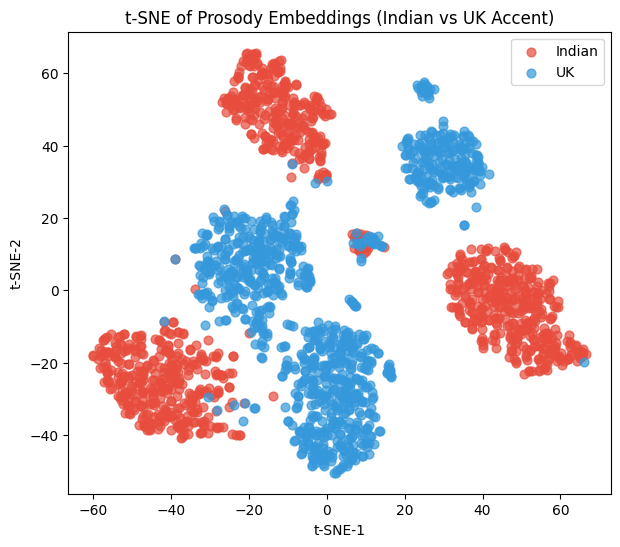

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=0)
proj = tsne.fit_transform(embeddings)

plt.figure(figsize=(7, 6))
colors = {"Indian": "#E74C3C", "UK": "#3498DB"}
for accent in ["Indian", "UK"]:
    idx = [i for i, l in enumerate(labels) if l == accent]
    plt.scatter(proj[idx, 0], proj[idx, 1], c=colors[accent], label=accent, alpha=0.7, s=40)

plt.legend()
plt.title("t-SNE of Prosody Embeddings (Indian vs UK Accent)")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.show()


Distinct regional clusters:

The red (Indian) and blue (UK) points form mostly non-overlapping groups.

That indicates your encoder is capturing accent-specific prosodic cues — things like rhythm (stress- vs syllable-timed), pitch range, and intonation slope.

A few overlaps:

The handful of mixed points likely correspond to utterances with neutral or less pronounced accent patterns, or recording artifacts.

This overlap is normal — even native British speakers can have flatter pitch in some sentences.

Multiple sub-clusters per accent:

Each accent has 2-3 dense blobs. Those often correspond to speaker or phonetic context differences — e.g., male/female pitch range, slow/fast tempo, or expressive vs neutral speech.

In [19]:
import numpy as np
corrs = [np.corrcoef(f_emb[:, i], f0)[0, 1] for i in range(f_emb.shape[1])]
print(f"Mean correlation with F0: {np.nanmean(corrs):.3f}")
top_dims = np.argsort(np.abs(corrs))[-5:]
print("Top 5 prosody-sensitive dims:", top_dims)


Mean correlation with F0: 0.015
Top 5 prosody-sensitive dims: [  4 119  70  23  42]
